In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import torch
import torch.nn.functional as F
import datetime as dt
from datetime import datetime
import matplotlib.dates as dates
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
import sys 
from scipy.stats import randint
from numpy.polynomial.polynomial import polyfit

from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM, TimeDistributed, Dense
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.layers import Dropout
import keras.backend as K

%matplotlib inline
plt.style.use('ggplot')

# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'public'
password = "jinaf3279"

con = psycopg2.connect(dbname=dbname, user=sqluser, password = password)
cur = con.cursor()
cur.execute('SET search_path to {}'.format(schema_name))

Using TensorFlow backend.
c:\users\wuyuef\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\wuyuef\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\wuyuef\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

In [3]:
#get subject_id who got CKD

def getSubID():
    query = """
    select subject_id from diagnoses_icd where icd9_code in ('5851','5852','5853','5854','5855','5859')
    """
    df = pd.read_sql_query(query,con)
    cur.execute("select subject_id from diagnoses_icd where icd9_code in ('5851','5852','5853','5854','5855','5859')")
    rows = cur.fetchall()
    subID=[]
    for r in rows:
        subID.append(r[0])
    return subID


In [4]:
#get CKD patients info

t = tuple(getSubID())
query = """
select subject_id, gender, dob, dod from patients where subject_id in {}
""".format(t)
df = pd.read_sql_query(query,con)
df

,subject_id,gender,dob,dod
0,68,F,2132-02-29,2174-02-11
1,85,M,2090-09-18,2167-09-12
2,109,F,2117-08-07,2142-08-30
3,124,M,2090-11-19,2166-02-01
4,145,F,2089-03-31,NaT
...,...,...,...,...
3779,99901,M,2104-03-10,NaT
3780,99923,M,2146-10-04,NaT
3781,99936,F,1882-10-10,2186-11-28
3782,99938,M,2119-12-23,NaT


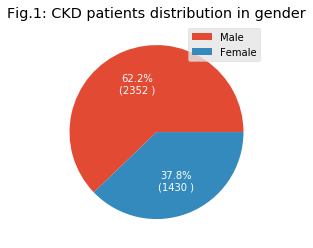

In [247]:
cur.execute("select subject_id, gender, dob, dod from patients where subject_id in {}".format(t))
rows = cur.fetchall()
gender = []
for r in rows:
    gender.append(r[1])

    
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} )".format(pct, absolute)

gender = [gender.count('M'),gender.count('F')]
label = ['Male', 'Female']
plt.pie(gender, labels=label, autopct=lambda pct: func(pct, gender),
       textprops=dict(color="w"))
plt.legend(label,loc="best")
plt.title('Fig.1: CKD patients distribution in gender')
plt.show()

In [125]:

cur.execute("select subject_id, gender, dob, dod from patients where subject_id in {}".format(t))
rows = cur.fetchall()
gender = []
for r in rows:
    gender.append(r[1])

gender = [gender.count('M'),gender.count('F')]
label = ['Male', 'Female']


In [150]:
# death rate by gender
male_l, fm_l, male_d, fm_d  = 0, 0, 0, 0

for r in rows:
    
    if r[3]==None:
        if r[1]=="M":
            male_l +=1
        elif r[1]=="F":
            fm_l+=1
    else:
        if r[1]=="M":
            male_d +=1
        elif r[1]=="":
            fm_d+=1
    

male_l, fm_l, male_d, fm_d

(1125, 652, 1228, 779)

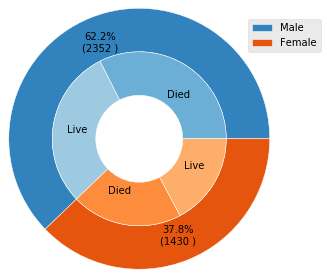

In [246]:
fig, ax = plt.subplots()

g = ['Died', 'Live', 'Died', 'Live']
vals = np.array([[male_d, male_l],[fm_d, fm_l]])

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.array([0,1,2,3])*4)
inner_colors = cmap([1,2,5,6])

ax.pie(vals.sum(axis=1), radius=1.5, colors=outer_colors,autopct=lambda pct: func(pct, gender),pctdistance = 0.8,
       wedgeprops=dict(width=.5, edgecolor='w'))

ax.pie(vals.flatten(), radius=1, colors=inner_colors,
       wedgeprops=dict(width=.5, edgecolor='w'),labels=g, labeldistance=0.6)

plt.legend(label, loc = (1,.9))
plt.show()


array([0, 1, 2, 3])